In [1]:
import numpy as np
import pandas as pd
import math
from pykalman import KalmanFilter
from matplotlib import pyplot as plt
% matplotlib inline

## 1. Read Data, Clean and Descriptive Plots

### 1.1 Read and clean SP and VX data. Set period starting from 2017 as out-of-sample trading period

In [2]:
# Set last day of in-sample period as Dec 31st 2016
in_sample_last = '2016-12-31'
in_sample_last_minus_half_year = '2016-07-01'

# Read S&P 500 VIX Futures close price
vx = pd.read_csv('S&P 500 VIX Futures Historical Data.csv', index_col=0)
vx.index = pd.to_datetime(vx.index)
vx = vx.iloc[::-1]
vx_close = vx['Price']

# Read S&P 500 Futures close price
sp = pd.read_csv('S&P 500 Futures Historical Data.csv', index_col=0)
sp.index = pd.to_datetime(sp.index)
sp = sp.iloc[::-1]
for idx, value in sp.iterrows():
    sp['Price'][idx] = value['Price'].replace(',', '')
sp_close = sp['Price']
sp_close = sp_close.astype('float64')

# Concatenate to form close price dataframe 'close_df'
close_df = pd.concat([vx_close, sp_close], axis=1)
close_df.columns = ['vx_close', 'sp_close']
close_df = close_df.interpolate(method='linear')
vx_close = close_df['vx_close']
sp_close = close_df['sp_close']

# Calculate daily return for S&P 500 VIX Futures using close price
vx_return = close_df['vx_close'].pct_change()
vx_return = vx_return.dropna()
vx_return.name = "vx_return"

# Calculate daily return for S&P 500 Futures using close price
sp_return = close_df['sp_close'].pct_change()
sp_return = sp_return.dropna()
sp_return.name = "sp_return"

# Create in-sample dataframe for close prices and returns for both VX and SP
vx_close_is = vx_close[vx_close.index <= in_sample_last]
vx_return_is = vx_return[vx_return.index <= in_sample_last]
sp_close_is = sp_close[sp_close.index <= in_sample_last]
sp_return_is = sp_return[sp_return.index <= in_sample_last]

# Create out-of-sample dataframe for close prices and returns for both VX and SP
vx_close_os = vx_close[vx_close.index > in_sample_last]
vx_return_os = vx_return[vx_return.index > in_sample_last]
sp_close_os = sp_close[sp_close.index > in_sample_last]
sp_return_os = sp_return[sp_return.index > in_sample_last]

print(vx_return_os.head())
print('')
print(sp_return_os.head())

Date
2017-01-02   -0.015873
2017-01-03   -0.073925
2017-01-04   -0.043541
2017-01-05   -0.011381
2017-01-06   -0.011512
Name: vx_return, dtype: float64

Date
2017-01-02    0.003130
2017-01-03    0.004123
2017-01-04    0.005216
2017-01-05    0.000000
2017-01-06    0.003202
Name: sp_return, dtype: float64


### 1.2 Plotting close prices and returns of SP and VX in the in-sample period

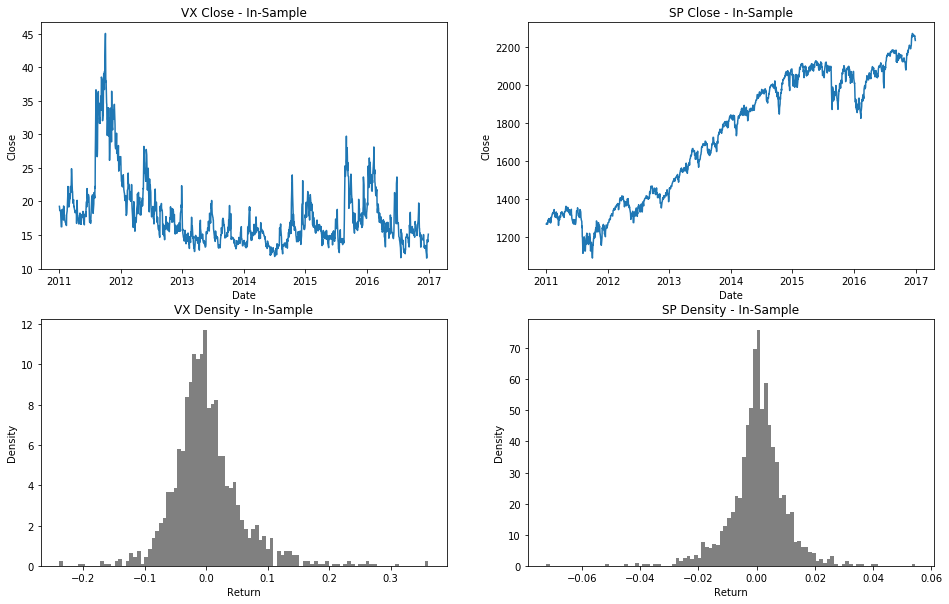

In [3]:
fig_1 = plt.figure(1, figsize=(16, 10))

#Plotting VX close prices for in-sample period
chart1 = fig_1.add_subplot(221)
chart1.plot(vx_close_is)
chart1.set_ylabel('Close')
chart1.set_xlabel('Date')
chart1.title.set_text('VX Close - In-Sample')

#Plotting SP close prices for in-sample period
chart2 = fig_1.add_subplot(222)
chart2.plot(sp_close_is)
chart2.set_ylabel('Close')
chart2.set_xlabel('Date')
chart2.title.set_text('SP Close - In-Sample')

#Plotting distribution for VX return for in-sample period
chart3 = fig_1.add_subplot(223)
chart3.hist(vx_return_is, density='True', bins=100, label='empirical', color='grey')
chart3.set_ylabel('Density')
chart3.set_xlabel('Return')
chart3.title.set_text('VX Density - In-Sample')

#Plotting distribution for SP return for in-sample period
chart4 = fig_1.add_subplot(224)
chart4.hist(sp_return_is, density='True', bins=100, label='empirical', color='grey')
chart4.set_ylabel('Density')
chart4.set_xlabel('Return')
chart4.title.set_text('SP Density - In-Sample')

plt.show()

# 2. Determining hedge ratio using Kalman Filter

### 2.1 Plotting in-sample VX return against SP return. Notice the inverse relationship. Therefore, we long VX to hedge against a long position in SP

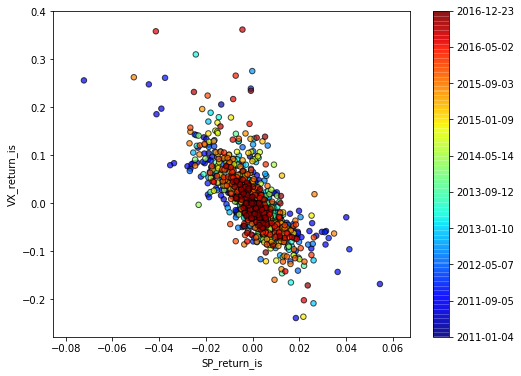

In [4]:
# Plotting VX return against SP return
plt.figure(figsize=(8,6))
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(sp_return_is))
sc = plt.scatter(sp_return_is, vx_return_is, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in sp_return_is[::len(sp_return_is)//9].index])
plt.xlabel('SP_return_is')
plt.ylabel('VX_return_is');

### 2.2 Determining hedge ratio for hedging SP using Pykalman for the in-sample period. The ratios are simply used for reference to understand the range of hedge ratio. A negative slope indicates a long position in VX to hedge against long position in SP
Notice that there is forward looking bias since:
- __Kalman smoothing__ is used to perform estimation which uses the in-sample dataset
- The transition covariance, observation covariance and initial state covariance are estimated by the Expectation maximization algorithm using the whole in-sample dataset

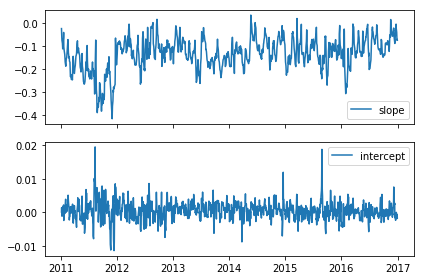

In [5]:
# Setting up KalmanFilter object
kf_is = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.zeros(2),
                  transition_matrices=np.eye(2),
                  observation_matrices=np.expand_dims(np.vstack([[vx_return_is], [np.ones(len(vx_return_is))]]).T, axis=1),
                  em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance'])

# Perform EM to estimate 'transition_covariance', 'observation_covariance' and 'initial_state_covariance' using in-sample data
# Perform smoothing on in-sample data
state_means_is, state_covs_is = kf_is.em(sp_return_is).smooth(sp_return_is)

# Plotting slop and intercept. The slope is the hedge ratio we are looking for. A negative slope indicates a long position.
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(vx_return_is.index, state_means_is[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(vx_return_is.index, state_means_is[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

### 2.3 Determining hedge ratio for hedging SP using Pykalman for the out-of-sample period
Notice that there is __no__ forward looking bias since:
- __Kalman filtering__ is used to perform estimation which uses data only up to the present time point
- The transition covariance, observation covariance and initial state covariance are estimated by the Expectation Maximization Algorithm using only the in-sample dataset

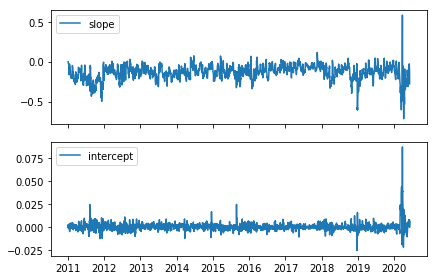

In [6]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.zeros(2),
                  transition_matrices=np.eye(2),
                  observation_matrices=np.expand_dims(np.vstack([[vx_return], [np.ones(len(vx_return))]]).T, axis=1),
                  em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance'])

# Perform EM to estimate 'transition_covariance', 'observation_covariance' and 'initial_state_covariance' using in-sample data
# Perform filtering on all data (including both in-sample and out-of-sample)
# We would only use the hedge ratios in the out-of-sample period later when developing strategy
state_means, state_covs = kf.em(sp_return_is).filter(sp_return)

# Plotting slop and intercept. The slope is the hedge ratio we are looking for. A negative slope indicates a long position.
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(vx_return.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(vx_return.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout()

### 2.4 Shifting the hedge ratios and returns accordingly to avoid forward looking bias:
For example:
- Hedge ratio generated on Jan-01 is used for trading on Jan-02
- Shift return such that return on Jan-02 corresponds to (close price on Jan-03 - close price on Jan-02)/close price on Jan-02

In [7]:
hedge_ratio = pd.DataFrame(state_means[:,0], index=vx_return.index, columns=['hedge_ratio'])
hedge_ratio_os = hedge_ratio[hedge_ratio.index > in_sample_last]

# Hedge ratio generated on Jan-02 is used for trading on Jan-03
hedge_ratio_os_shifted = hedge_ratio_os.shift(1)
hedge_ratio_os_shifted = hedge_ratio_os_shifted.dropna()

# Shift return such that return on Jan-03 corresponds to (close price on Jan-04 - close price on Jan-03)/close price on Jan-03
vx_return_os_shifted = vx_return_os.shift(-1)
sp_return_os_shifted = sp_return_os.shift(-1)

os_df = pd.concat([hedge_ratio_os_shifted, vx_return_os_shifted, sp_return_os_shifted], axis=1)
os_df = os_df.dropna()
os_df['sp_cumulative_return'] = os_df['sp_return'].cumsum()

os_df.head()

,hedge_ratio,vx_return,sp_return,sp_cumulative_return
Date,,,,
2017-01-03,-0.103831,-0.043541,0.005216,0.005216
2017-01-04,-0.066422,-0.011381,0.000000,0.005216
2017-01-05,-0.071600,-0.011512,0.003202,0.008418
2017-01-06,-0.080901,0.003882,-0.002862,0.005557
2017-01-09,-0.078788,-0.003867,-0.000552,0.005005


In [8]:
os_df.to_excel('os_df.xlsx')
sp_return[sp_return.index >= in_sample_last_minus_half_year].to_csv('SP_Return_os.csv')

# 3. Determining Hedge Timing

We are going to explore two methods for determining the hedge timing. <Br>
- 1st Method: Determining Hedge Timing using Equity Turbulence Index and Hidden Markov Model. Idea comes from paper Kritzman et al. (2012) https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2064801
- 2nd Method: Determining Hedge Timing using change point analysis. Idea comes from paper Nystrup, P., Hansen, B. W., Madsen, H., and Lindström, E. (2016) https://orbit.dtu.dk/en/publications/detecting-change-points-in-vix-and-sampp-500-a-new-approach-to-dy
 
  

## 3a. Determining Hedge Timing using Daily Equity Turbulence Index and Hidden Markov Model

### 3a1. Reading Equity Turbulence Index Data. An daily Equity Turbulence Index is created according to the method described in the paper using returns of 11 S&P 500 sector indices. Please refer to 'Turbulence Index.ipynb' for detail

In [9]:
turb = pd.read_csv('Turbulence Index.csv', index_col=0)
turb.index = pd.to_datetime(turb.index)
close_df = close_df.join(turb['Close'], how='left')

# For days with missing data in daily turbulence index, we simply fill in previous values
close_df.fillna(method='ffill', inplace=True)

close_df.columns = ['vx_close', 'sp_close', 'turb_close']
close_df['turb_close'] = close_df['turb_close'].interpolate(method='linear')
turb_close = close_df['turb_close']

turb_close_is = turb_close[turb_close.index <= in_sample_last]
turb_close_os = turb_close[turb_close.index > in_sample_last]

turb_close_os.head()

Date
2017-01-02     3.652937
2017-01-03     8.456187
2017-01-04     8.006948
2017-01-05     2.888359
2017-01-06    16.093675
Name: turb_close, dtype: float64

### 3a2. Plotting Equity Turbulence Index

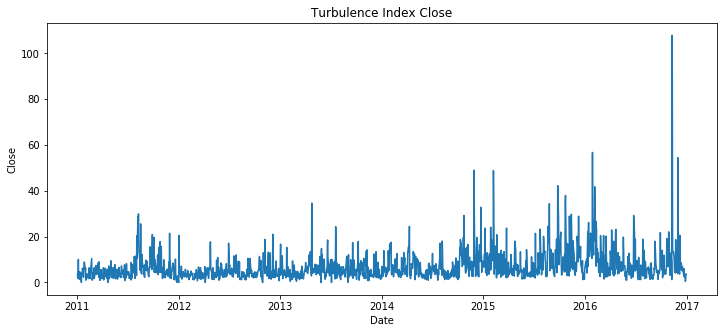

In [10]:
fig_2 = plt.figure(2, figsize=(12, 5))

chart5 = fig_2.add_subplot(111)
chart5.plot(turb_close_is)
chart5.set_ylabel('Close')
chart5.set_xlabel('Date')
chart5.title.set_text('Turbulence Index Close')

### 3a3. Implementation of Forward Algorithm and Baum Welch Algorithm

Reference:
- Kritzman, Mark and Page, Sebastien and Turkington, David, Regime Shifts: Implications for Dynamic Strategies (May 22, 2012). Financial Analysts Journal, Vol. 68, No. 3, 2012. Available at SSRN: https://ssrn.com/abstract=2064801

In [11]:
def forward_algo(v, mu, sigma, a, initial_distribution):
    T = len(v)
    b = np.zeros((T, 2))
    
    for t in range(T):
        b[t, 0] = np.exp(-0.5 * ((v[t]-mu[0][0])/sigma[0][0])**2)/np.sqrt(2*math.pi)/sigma[0][0]
        b[t, 1] = np.exp(-0.5 * ((v[t]-mu[0][1])/sigma[0][1])**2)/np.sqrt(2*math.pi)/sigma[0][1]

    forward = np.zeros((v.shape[0], a.shape[0]))
    scale = np.zeros((v.shape[0], a.shape[0]))
    forward[0, :] = b[0, :] * initial_distribution
    scale[0, :] = np.sum(forward[0, :])
    forward[0, :] = forward[0, :]/np.sum(forward[0, :])
    for t in range(1, T):
        forward[t, :] = forward[t-1, :].dot(a) * b[t, :]
        scale[t, :] = np.sum(forward[t, :])
        forward[t, :] = forward[t, :]/np.sum(forward[t, :])
    
    return(forward)
    

def baum_welch(v, mu, sigma, a, initial_distribution):
    T = len(v)
    b = np.zeros((T, 2))

    likelihood = -999
    change_likelihood = 999
    tolerance = 0.001
    
    while change_likelihood > tolerance:      
        for t in range(T):
            b[t, 0] = np.exp(-0.5 * ((v[t]-mu[0][0])/sigma[0][0])**2)/np.sqrt(2*math.pi)/sigma[0][0]
            b[t, 1] = np.exp(-0.5 * ((v[t]-mu[0][1])/sigma[0][1])**2)/np.sqrt(2*math.pi)/sigma[0][1]

        forward = np.zeros((v.shape[0], a.shape[0]))
        scale = np.zeros((v.shape[0], a.shape[0]))
        forward[0, :] = b[0, :] * initial_distribution
        scale[0, :] = np.sum(forward[0, :])
        forward[0, :] = forward[0, :]/np.sum(forward[0, :])
        for t in range(1, T):
            forward[t, :] = forward[t-1, :].dot(a) * b[t, :]
            scale[t, :] = np.sum(forward[t, :])
            forward[t, :] = forward[t, :]/np.sum(forward[t, :])
            
        backward = np.zeros((v.shape[0], a.shape[0]))
        backward[-1, :] = b[-1: ]
        backward[-1, :] = backward[-1, :]/sum(backward[-1, :])
        for t in range(T-2, -1, -1):
            backward[t, :] = (a.dot(backward[t+1, :].T)).T * b[t+1, :]
            backward[t, :] = backward[t, :]/np.sum(backward[t, :])

        smoothed = np.zeros((v.shape[0], a.shape[0]))
        for t in range(T):
            smoothed[t, :] = forward[t, :] * backward[t, :]
            smoothed[t, :] = smoothed[t, :]/np.sum(smoothed[t, :])

        xi = np.zeros((2, 2, T-1))
        for t in range(T-1): 
            xi[:, :, t] = a * (np.array([forward[t, :]]).T.dot(np.array([backward[t+1, :] * b[t+1, :]])))
            xi[:, :, t] = xi[:, :, t]/np.sum(np.sum(xi[:, :, t], axis=1))
        
        p = smoothed[0, :]
        exp_num_transition = np.sum(xi, axis=2)
        a[0, :] = exp_num_transition[0, :]/np.sum(smoothed[1:T, :])
        a[1, :] = exp_num_transition[1, :]/np.sum(smoothed[1:T, :])
        mu[0][0] = (smoothed[:, 0].T.dot(v)).T/np.sum(smoothed[:, 0])
        mu[0][1] = (smoothed[:, 1].T.dot(v)).T/np.sum(smoothed[:, 1])
        sigma[0][0] = np.sqrt(np.sum(smoothed[:, 0] * (v-mu[0][0]) ** 2)/np.sum(smoothed[:, 0]))
        sigma[0][1] = np.sqrt(np.sum(smoothed[:, 1] * (v-mu[0][1]) ** 2)/np.sum(smoothed[:, 1]))

        tmp_likelihood = np.sum(np.sum(np.log(scale)))
        change_likelihood = np.abs(tmp_likelihood - likelihood)
        likelihood = tmp_likelihood   
    
    return mu, sigma, a
        

### 3a4. Inferring the probabilities for high volatility regime and low volatilty regime

- We first calibrate the two-regime Markov Switching Model using the in-sample turbulence index and the __Baum Welch Algorithm__. 
- Then, we infer the probabilities for high volatility regime and low volatility regime for the whole turbulence index data set (both in-sample and out-of-sample period) using the __Forward Algorithm__. 
    - Only regime data for out-of-sample period will be used
    - A __signal of '1'__ is generated when Probaility of high volatility regime is greater than Probaility of low volatility regime, __indicating that we are currently in a high volatility regime__

In [12]:
# Calibrating the Markow Switching Model using the Baum Welch Algorithm
v = turb_close_is.values
mu = np.mean(v) + np.std(v) * np.random.randn(1,2)
sigma = np.zeros((1,2)) + np.std(v)
a = np.ones((2, 2))
a = a / np.sum(a, axis=1)
initial_distribution = np.array((0.5, 0.5))
mu_bw, sigma_bw, a_bw = baum_welch(v, mu, sigma, a, initial_distribution)

# Infer the probabilities for high volatility regime and low volatility regime using the Forward Algorithm
regime_prob_array = forward_algo(turb_close.values, mu_bw, sigma_bw, a_bw, initial_distribution)
regime_prob_df = pd.DataFrame(regime_prob_array, index=turb_close.index)
regime_prob_df.columns = ['Regime_0', 'Regime_1']
regime_prob_df = regime_prob_df.join(turb_close, how='left')

# Simply to find out whether regime_0 or regime_1 correpsonds to the high volatility regime
signal = regime_prob_df['Regime_0'] > regime_prob_df['Regime_1']
if (regime_prob_df['turb_close'][signal]).mean() > (regime_prob_df['turb_close'][~signal]).mean():
    regime_prob_df['hmm_signal'] = signal
else:
    regime_prob_df['hmm_signal'] = ~signal

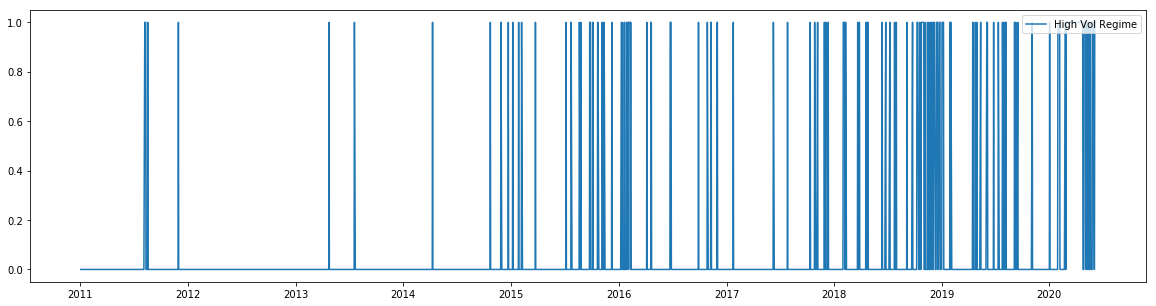

In [13]:
regime_prob_df.columns
plt.figure(figsize=(20,5))
plt.plot(regime_prob_df['hmm_signal'], label='High Vol Regime')
plt.legend(loc="upper right")

### 3a5. Shifting the HMM signal accordingly to avoid forward looking bias:
For example:
- HMM signal generated on Jan-02 is used for trading on Jan-03

In [14]:
# Regime signal generated on Jan-02 is used for trading on Jan-03
hmm_signal = regime_prob_df['hmm_signal'].shift(1)
hmm_signal = hmm_signal.dropna()

os_df = os_df.join(hmm_signal).join(turb_close).join(sp_close)
os_df = os_df
os_df.head()

,hedge_ratio,vx_return,sp_return,sp_cumulative_return,hmm_signal,turb_close,sp_close
Date,,,,,,,
2017-01-03,-0.103831,-0.043541,0.005216,0.005216,False,8.456187,2252.50
2017-01-04,-0.066422,-0.011381,0.000000,0.005216,False,8.006948,2264.25
2017-01-05,-0.071600,-0.011512,0.003202,0.008418,False,2.888359,2264.25
2017-01-06,-0.080901,0.003882,-0.002862,0.005557,False,16.093675,2271.50
2017-01-09,-0.078788,-0.003867,-0.000552,0.005005,False,8.792234,2265.00


### 3a6. Plotting theoretical cumulative return for the strategy

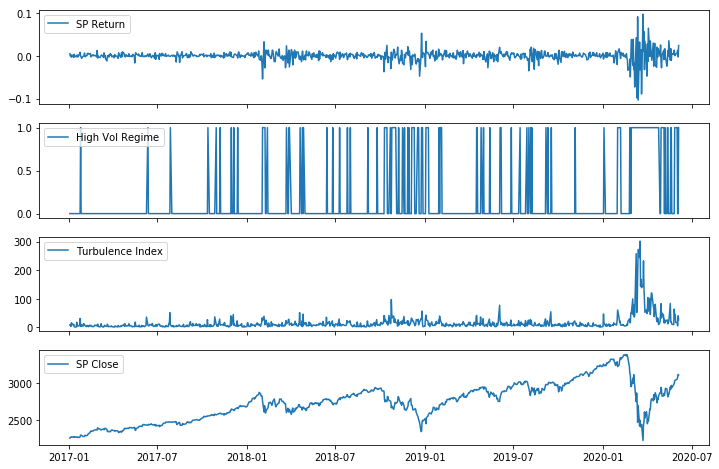

In [15]:
_, axarr = plt.subplots(4, sharex=True, figsize=(12,8))

# Plotting daily return for S&P 500 Futures
axarr[0].plot(os_df.index, os_df['sp_return'], label='SP Return')
axarr[0].legend(loc='upper left')

# Plotting regime signal generated from HMM model
axarr[1].plot(os_df.index, os_df['hmm_signal'], label='High Vol Regime')
axarr[1].legend(loc='upper left')

# Plotting Turbulence Index
axarr[2].plot(os_df.index, os_df['turb_close'], label='Turbulence Index')
axarr[2].legend(loc='upper left')

# Plotting close price for S&P 500 Futures
axarr[3].plot(os_df.index, os_df['sp_close'], label='SP Close')
axarr[3].legend(loc='upper left')

plt.show()

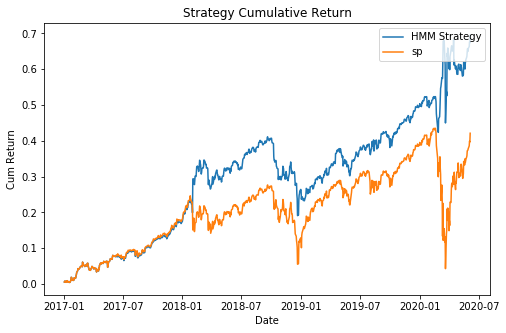

In [16]:
# Calculating strategy return
os_df['hmm_strategy_return'] = os_df['sp_return'] - os_df['hmm_signal'] * os_df['hedge_ratio'] * os_df['vx_return']
os_df['hmm_strategy_cumulative_return'] = os_df['hmm_strategy_return'].cumsum()

# PLotting cummulative return for HMM strategy against benchmark portfolio of longing S&P 500 Futures
fig_2 = plt.figure(1, figsize=(8, 5))

chart5 = fig_2.add_subplot(111)
chart5.plot(os_df['hmm_strategy_cumulative_return'], label='HMM Strategy')
chart5.plot(os_df['sp_cumulative_return'], label='sp')
chart5.set_ylabel('Cum Return')
chart5.set_xlabel('Date')
chart5.title.set_text('Strategy Cumulative Return')
chart5.legend(loc='upper right', fontsize=10)
plt.show()

## 3b. Determining Hedge Timing using change point analysis

### 3b1. Read 'Change_Time.csv' and 'Detection_Time.csv' which are output files from 'change_point.R'.
- 'Change_Time.csv' stores the row number at which the change point occurs
- 'Detection_Time.csv' stores the row number after which the corresponding change point in 'Change_Time.csv' is detected

Referring to below table, according to the first row, __the first change point is detected when we reach row 54__ and the __corresponding change point occured right after row 51__. For detail, please see:
- Nystrup, P., Hansen, B. W., Madsen, H., & Lindström, E. (2016) for the idea of change point analysis
- https://cran.r-project.org/web/packages/cpm/cpm.pdf for the detail of the CPM package used for change point detection, in particular the __'processStream' function__ described

In [17]:
change_time = pd.read_csv('Change_Time.csv')
change_time.columns = ['Change Time']

detection_time = pd.read_csv('Detection_Time.csv')
detection_time.columns = ['Detection Time']

change_point = pd.concat([change_time, detection_time], axis=1)
change_point

,Change Time,Detection Time
0,51,54
1,57,136
2,121,177
3,278,290
4,293,298
5,318,328
6,345,419
7,409,422
8,469,501
9,599,604


### 3b2. This section shows the logic for determining the hedge timing according to the change time and detection time above

The following tap shows an example: <br>
1. Note that the first change point is detected when we reach __row 54__ and the corresponding change point occurs __right after row 51__. (Note that row 54 and row 51 here is a counter starting form index 1, this corresponds to row 53 and row 50 for Python counter starting from index 0. To avoid confusion, all description in the markdown would follow index 1 while the code would output the corresponding result) 

<br>

2. We then use min(5, detection time - change time) =  min(5, 54-51) = 3 days before and after the change point to calculate the change in variance

<br>
- Variance of returns for row 52 to 54 = 0.0002939874399225946 <br>
- Variance of returns for row 49 to 51 = 3.1689340512731603e-06 <br>
- Variance change = 0.0002939874399225946 / 3.1689340512731603e-06 = 92.77171287439111 which __signifies an increase in volatility__

<br>
We then perform hedging starting from __row 55__ onward __until the next change point is detected and the corresponding change point signifies a decrease in volatility__


In [18]:
sp_return = pd.read_csv('SP_Return_os.csv', index_col=0, header=None)
sp_return.columns = ['Return']
print(sp_return.iloc[48:54], '\n')

print('Variance of returns for row 52-54 = ', sp_return.iloc[51:54].values.var())
print('Variance of returns for row 49-51 = ', sp_return.iloc[48:51].values.var())
print('Variance change = ', sp_return.iloc[51:54].values.var()/sp_return.iloc[48:51].values.var())


              Return
0                   
2016-09-05 -0.001261
2016-09-06  0.002984
2016-09-07  0.000000
2016-09-08 -0.003204
2016-09-09 -0.025144
2016-09-12  0.016841 

Variance of returns for row 52-54 =  0.0002939874399225946
Variance of returns for row 49-51 =  3.1689340512731603e-06
Variance change =  92.77171287439111


In [19]:
## Code for implementing the idea in the above tap

i = 0 
action = 2
j = 0

hedge_signal_arr = []
var_change_arr = []

while i < len(change_point):
        
    detection_time_tmp = change_point.iloc[i].loc['Detection Time'] 
    change_time_tmp = change_point.iloc[i].loc['Change Time'] 
    
    if j < detection_time_tmp:
        hedge_signal_arr.append(action)
    else:
        offset = min(5, detection_time_tmp - change_time_tmp)
        var_change = sp_return.iloc[change_time_tmp:(change_time_tmp + offset)].var() / sp_return.iloc[change_time_tmp - offset:change_time_tmp].var() 
        var_change_arr.append(var_change)
        if var_change.values[0] >= 1:
            action = 1
        else:
            action = 0
        hedge_signal_arr.append(action)
        
        i = i + 1
    
    j = j + 1


while j < len(sp_return):
    hedge_signal_arr.append(action)
    j = j + 1

The following tap shows the resulting __hedging timing__, where:
- __2__ is inputed until we have the first change point detected
- __1__ means perform hedging 
- __0__ means not perform hedging

<br>
The corresponding __changes in variance for each change point detected__ are also printed. Note that the first value (92.771713) matches the above example


<br>
Note that '2' is inputted from the start till row 54 (since the first change point is detected when we reach row 54). Since an increase in volatlity is detected, we __perform hedging starting from row 55 until two conditions are satisfied__:
- A new change point is detected 
- The new change point signifies a decrease in volatility

In [20]:
hedge_signal_changepoint_df = pd.DataFrame(hedge_signal_arr, index=sp_return.index, columns=['change_point_signal'])
var_change_df = pd.DataFrame(var_change_arr)
var_change_df.columns = ['variance change']

print(var_change_df, '\n')

print(hedge_signal_changepoint_df[48:55])

    variance change
0         92.771713
1          0.135385
2          0.284514
3          0.245960
4         32.972223
5          0.048399
6         46.001924
7          0.951696
8          0.255973
9         13.916241
10         0.023576
11        58.280865
12         0.176693
13         0.682979
14       108.056868
15        13.796937
16         0.162269 

            change_point_signal
0                              
2016-09-05                    2
2016-09-06                    2
2016-09-07                    2
2016-09-08                    2
2016-09-09                    2
2016-09-12                    2
2016-09-13                    1


### 3b3. Plotting theoretical cumulative return for the strategy

- First, we plot out the __SP return, hedging signal from change point method (section 3b), hedging signal from HMM method (section 3a) and daily turbulence index (section 3a)__ for the out-of-sample trading period. 
- Recall that we perform hedging when hedging signal is 1, __signifying a high volatility regime__. As shown below, change point analysis helps us identify high volatility regime better since HMM method has a lot of 'noise'

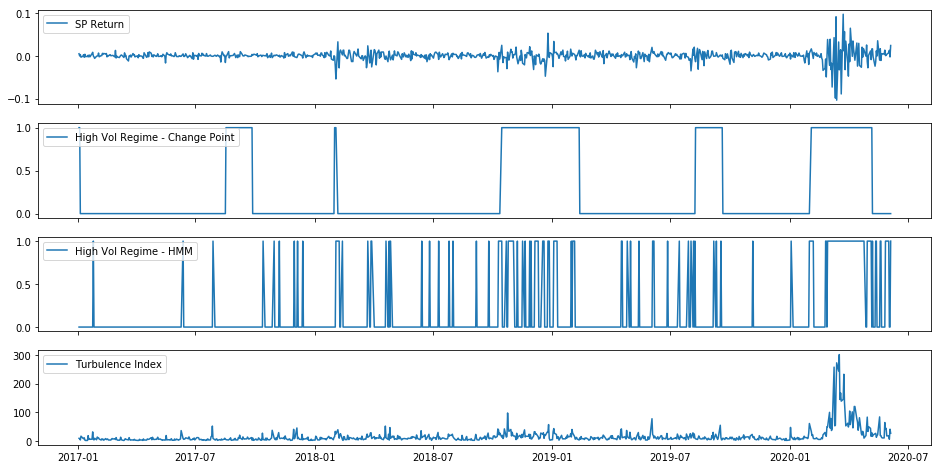

In [21]:
os_df = os_df.join(hedge_signal_changepoint_df)

_, axarr = plt.subplots(4, sharex=True, figsize=(16,8))
axarr[0].plot(os_df.index, os_df['sp_return'], label='SP Return')
axarr[0].legend(loc='upper left')
axarr[1].plot(os_df.index, os_df['change_point_signal'], label='High Vol Regime - Change Point')
axarr[1].legend(loc='upper left')
axarr[2].plot(os_df.index, os_df['hmm_signal'], label='High Vol Regime - HMM')
axarr[2].legend(loc='upper left')
axarr[3].plot(os_df.index, os_df['turb_close'], label='Turbulence Index')
axarr[3].legend(loc='upper left')
plt.show()

__Theoretical Strategy Return = SP Return - Change Point Signal $*$ Hedge Ratio $*$ VX Return__
- The theoretical return is simply for reference. Refer to section 4 for execution and NAV calculation

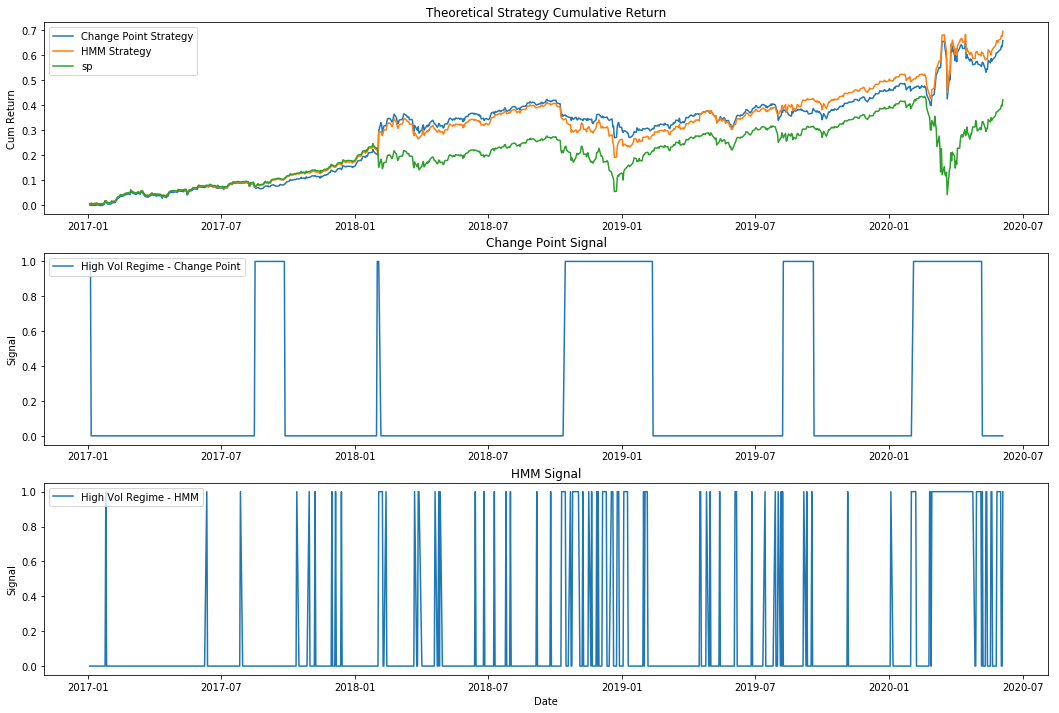

In [22]:
os_df['change_point_strategy_return'] = os_df['sp_return'] - os_df['change_point_signal'] * os_df['hedge_ratio'] * os_df['vx_return']
os_df['change_point_strategy_cumulative_return'] = os_df['change_point_strategy_return'].cumsum()

fig_3 = plt.figure(1, figsize=(18, 12))
chart6 = fig_3.add_subplot(311)
chart6.plot(os_df['change_point_strategy_cumulative_return'], label='Change Point Strategy')
chart6.plot(os_df['hmm_strategy_cumulative_return'], label='HMM Strategy')
chart6.plot(os_df['sp_cumulative_return'], label='sp')
chart6.set_ylabel('Cum Return')
chart6.title.set_text('Theoretical Strategy Cumulative Return')
chart6.legend(loc='upper left', fontsize=10)

chart7 = fig_3.add_subplot(312)
chart7.plot(os_df['change_point_signal'], label='High Vol Regime - Change Point')
chart7.set_ylabel('Signal')
chart7.title.set_text('Change Point Signal')
chart7.legend(loc='upper left', fontsize=10)

chart8 = fig_3.add_subplot(313)
chart8.plot(os_df['hmm_signal'], label='High Vol Regime - HMM')
chart8.set_ylabel('Signal')
chart8.set_xlabel('Date')
chart8.title.set_text('HMM Signal')
chart8.legend(loc='upper left', fontsize=10)



plt.show()

## 3C. Discussion and Comparison on HMM Strategy and Change Point Strategy

__1. In general, both strategies perform better than the benchmark portfolio (Long SP):__
- Hedging signals generated by both strategies was able to help prevent large drawdowns in a simple buy-and-hold strategy
- In particular, both strategies were able to avoid/reduce major losses in early 2018Q1 and 2020Q1

__2. Change Point Strategy is performing better the HMM Strategy in several aspects (although the returns for both strategies are similar):__
- Change Point analysis was able to identify high volatility period in SP more accurately than HMM (See plots in tab 21)
    - This may be partly due to the fact that the daily turbulence index does not precisely reflect volatility in SP
    - Another possible reason is that turbulence index may work better for data with lower resolution e.g. monthly or weekly data
    - There were periods where daily turbulence index was at a low level but volatility of SP was high and vice versa
- HMM method alternates between low and high volatility regime much more frequently than Change Point method (See plots in tab 22)
    - This makes HMM strategy less attractive since it would require much more frequeny rebalancing and higher transaction cost
    
__Therefore, we would focus on conducting backtesting on Change Point Strategy__
    

# 4. Execution and NAV Calculation on Change Point Strategy

In [23]:
trade_change_point_df = os_df[['hedge_ratio', 'change_point_signal']]
trade_change_point_df = trade_change_point_df.join(vx_close_os, how='left')
trade_change_point_df.columns = ['hedge_ratio', 'change_point_signal', 'vx_close']

trade_change_point_df = trade_change_point_df.join(sp_close_os, how='left')
trade_change_point_df.columns = ['hedge_ratio', 'change_point_signal', 'vx_close', 'sp_close']

trade_change_point_df.head()

,hedge_ratio,change_point_signal,vx_close,sp_close
Date,,,,
2017-01-03,-0.103831,1,13.78,2252.50
2017-01-04,-0.066422,1,13.18,2264.25
2017-01-05,-0.071600,0,13.03,2264.25
2017-01-06,-0.080901,0,12.88,2271.50
2017-01-09,-0.078788,0,12.93,2265.00


### Execution Procedure and Assumptions:
__Procedure__
<br>
We start with USD 10,000,000 capital
<br>
<br>
At inception (2017-01-03), hedging is needed since the hedging signal is 1:
- Allocate capital in the required ratio into long position of SP and long position of VX. Remaining capital is left as cash


After inception, i.e. 2017-01-04 onward:
- Firstly, check if hedging is needed
    - Case 1: Hedging is not needed
        - Put all available capital into long position of SP
    - Case 2: Hedging is needed
        - Case 2a: Current hedge ratio deviates from target hedge ratio by more than 5%
            - Rebalance
        - Case 2b: Current hedge ratio deviates from target hedge ratio by less than 5%
            - Maintain current position

<br>
        
__Benchmark__
- Long position in SP 

<br>

__Transaction cost assumption for ES-mini:__
- __Commission__: USD 0.85 per contract (https://www.interactivebrokers.com/en/index.php?f=1590&p=futures1)
- __Exchange fee__: USD 1.23 per contract (https://www.tradestation.com/pricing/exchange-execution-and-clearing-fees/)
- __NFA Regulatory Fee__ : USD 0.02 per contract (https://www.tradestation.com/pricing/exchange-execution-and-clearing-fees/)
- __Bid-Ask Spread__: USD 12.5 per contract (0.25 per tick * 50)
- __Market Impact__: Assume 0.125 bps (https://www.cmegroup.com/trading/equity-index/report-a-cost-comparison-of-futures-and-etfs.html)
    - According to research from CME, the market impact of the hypothetical USD 100 million order is estimated to be 1.25bps for E-mini futures. Since we have USD 10 million capital, assume 0.125 bps for simplicity
    
<br>
__Transaction cost assumption for VX:__
- __Commission__: USD 0.85 per contract (https://www.interactivebrokers.com/en/index.php?f=1590&p=futures1)
- __Exchange fee__: USD 1.49 per contract (https://www.tradestation.com/pricing/exchange-execution-and-clearing-fees/)
- __NFA Regulatory Fee__ : USD 0.02 per contract (https://www.tradestation.com/pricing/exchange-execution-and-clearing-fees/)
- __Bid-Ask Spread__: USD 50 per contract (0.05 per tick * 1000)
- __Market Impact__: Assume 0.125 bps for simplicity


In [24]:
trade_change_point_dict = {}
previous_arr = []
initial_cap = 10000000

for idx, row in trade_change_point_df.iterrows():
    hedge_signal = row['change_point_signal']
    target_hedge_ratio = row['hedge_ratio'] * hedge_signal * -1
    
    if idx == trade_change_point_df.index[0]: 
        vx_target_value = int(initial_cap * target_hedge_ratio/(1 + np.abs(target_hedge_ratio)))
        sp_target_value = int(initial_cap / (1 + np.abs(target_hedge_ratio)))
        
        vx_target_num = int(vx_target_value / row['vx_close'] / 1000)
        sp_mini_target_num = int(sp_target_value / row['sp_close'] / 50)
        
        vx_position_num = vx_target_num
        sp_mini_position_num = sp_mini_target_num
        
        vx_position_change = vx_target_num
        sp_mini_position_change = sp_mini_target_num
        
        vx_position_value = vx_position_num * row['vx_close'] * 1000
        sp_mini_position_value = sp_mini_position_num * row['sp_close'] * 50
        cost = 14.6 * np.abs(sp_mini_position_change) + 52.36 * np.abs(vx_position_change) + \
               0.125/10000 * (np.abs(vx_position_change) * row['vx_close'] * 1000 + np.abs(sp_mini_position_change) * row['sp_close'] * 50)
        cash = initial_cap - vx_position_value - sp_mini_position_value - cost
        portfolio_nav = vx_position_value + sp_mini_position_value + cash
        current_hedge_ratio = vx_position_value/(vx_position_value + sp_mini_position_value)
        
        trade_change_point_dict[idx] = [target_hedge_ratio, hedge_signal, current_hedge_ratio, vx_target_value, sp_target_value, vx_target_num, \
                                        sp_mini_target_num, vx_position_num, sp_mini_position_num, vx_position_change, sp_mini_position_change, \
                                        vx_position_value, sp_mini_position_value, cost, cash, portfolio_nav]
        previous_arr = trade_change_point_dict[idx]
        
    else:
        current_hedge_ratio = previous_arr[7] * row['vx_close'] * 1000 / (np.abs(previous_arr[7] * row['vx_close'] * 1000) + np.abs(previous_arr[8] * row['sp_close'] * 50))
        available_capital = previous_arr[-2] + previous_arr[7] * row['vx_close'] * 1000 + previous_arr[8] * row['sp_close'] * 50
        
        if target_hedge_ratio == 0:
            vx_target_value = np.nan
            sp_mini_target_value = np.nan
            vx_target_num = np.nan
            sp_mini_target_num = np.nan
            
            vx_position_change = -1 * previous_arr[7]
            vx_position_num = 0
            
            sp_mini_position_num = int(available_capital/row['sp_close']/50)
            sp_mini_position_change = sp_mini_position_num - previous_arr[8]
            
        else:
            if np.abs(current_hedge_ratio - target_hedge_ratio) > 0.03:
                vx_target_value = int(available_capital * target_hedge_ratio/(1 + np.abs(target_hedge_ratio)))
                sp_target_value = int(available_capital / (1 + np.abs(target_hedge_ratio)))
                
                vx_target_num = int(vx_target_value / row['vx_close'] / 1000)
                sp_mini_target_num = int(sp_target_value / row['sp_close'] / 50)
                
                vx_position_num = vx_target_num
                sp_mini_position_num = sp_mini_target_num
                
                vx_position_change = vx_position_num - previous_arr[7]
                sp_mini_position_change = sp_mini_position_num - previous_arr[8]
                
            else:
                vx_target_value = np.nan
                sp_mini_target_value = np.nan
                vx_target_num = np.nan
                sp_mini_target_num = np.nan
                
                vx_position_num = previous_arr[7]
                vx_position_change = 0
            
                sp_mini_position_num = previous_arr[8]
                sp_mini_position_change = 0
       

        vx_position_value = vx_position_num * row['vx_close'] * 1000
        sp_mini_position_value = sp_mini_position_num * row['sp_close'] * 50
        cost = 14.6 * np.abs(sp_mini_position_change) + 52.36 * np.abs(vx_position_change) + \
                0.125/10000 * (np.abs(vx_position_change) * row['vx_close'] * 1000 + np.abs(sp_mini_position_change) * row['sp_close'] * 50)
        cash = previous_arr[-2] - vx_position_change * row['vx_close'] * 1000 - sp_mini_position_change * row['sp_close'] * 50
        portfolio_nav = vx_position_value + sp_mini_position_value + cash
        current_hedge_ratio = vx_position_value/(np.abs(vx_position_value) + np.abs(sp_mini_position_value))
        
        trade_change_point_dict[idx] = [target_hedge_ratio, hedge_signal, current_hedge_ratio, vx_target_value, sp_target_value, vx_target_num, sp_mini_target_num, \
                                        vx_position_num, sp_mini_position_num, vx_position_change, sp_mini_position_change, \
                                        vx_position_value, sp_mini_position_value, cost, cash, portfolio_nav]
        
        previous_arr = trade_change_point_dict[idx]
    
                

### Plotting Portfolio and Benchmark NAV

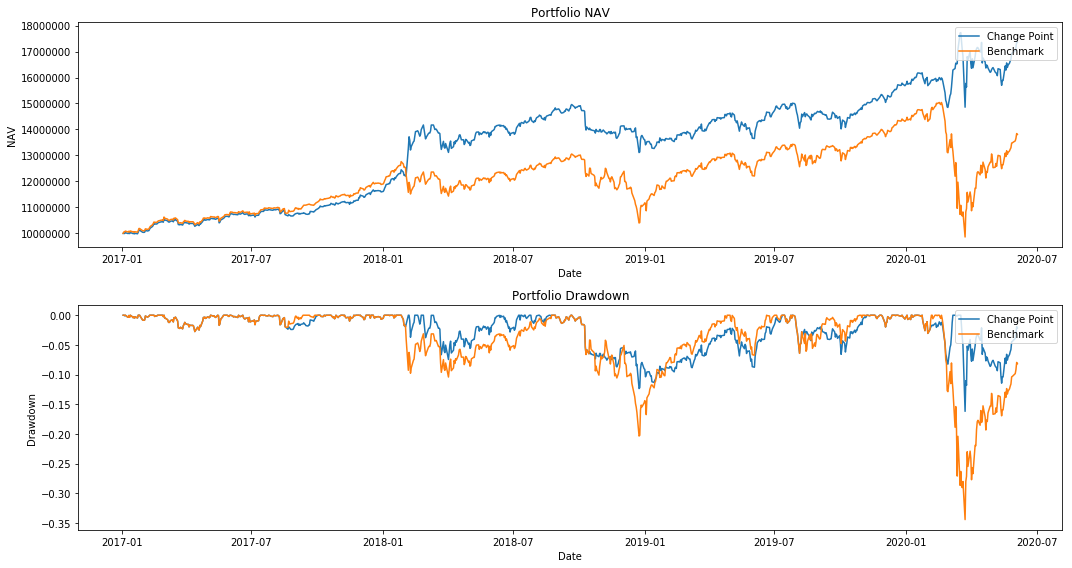

In [25]:
trade_change_point_backtest = pd.DataFrame.from_dict(trade_change_point_dict, orient='index')
trade_change_point_backtest.columns = ['target_hedge_ratio', 'hedge_signal', 'current_hedge_ratio', 'vx_target_value', 'sp_target_value', 'vx_target_num', 'sp_mini_target_num', \
                                 'vx_position_num', 'sp_mini_position_num', 'vx_position_change', 'sp_mini_position_change', \
                                 'vx_position_value', 'sp_mini_position_value', 'cost', 'cash', 'portfolio_nav']
trade_change_point_backtest['portfolio_daily_dollar_return'] = trade_change_point_backtest['portfolio_nav'].diff() 
trade_change_point_backtest['portfolio_daily_pct_return'] = trade_change_point_backtest['portfolio_nav'].diff() \
                                                        / trade_change_point_backtest['portfolio_nav'].shift(1)
drawdown_arr = []
for i in range(len(trade_change_point_backtest['portfolio_nav'])):
    max_nav = np.max(trade_change_point_backtest['portfolio_nav'][0:i+1])
    drawdown_arr.append(trade_change_point_backtest['portfolio_nav'][i]/max_nav - 1)
trade_change_point_backtest['portfolio_drawdown'] = drawdown_arr    



num_sp_inception = initial_cap / trade_change_point_df.loc[trade_change_point_df.index[0]]['sp_close'] / 50
trade_change_point_backtest['benchmark_nav'] = num_sp_inception * trade_change_point_df['sp_close'] * 50
trade_change_point_backtest['benchmark_daily_dollar_return'] = trade_change_point_backtest['benchmark_nav'].diff() 
trade_change_point_backtest['benchmark_daily_pct_return'] = trade_change_point_backtest['benchmark_nav'].diff() \
                                                        / trade_change_point_backtest['benchmark_nav'].shift(1)
drawdown_arr = []
for i in range(len(trade_change_point_backtest['benchmark_nav'])):
    max_nav = np.max(trade_change_point_backtest['benchmark_nav'][0:i+1])
    drawdown_arr.append(trade_change_point_backtest['benchmark_nav'][i]/max_nav - 1)
trade_change_point_backtest['benchmark_drawdown'] = drawdown_arr 


trade_change_point_backtest.to_excel('Strategy Change Point Backtest.xlsx')

fig_4 = plt.figure(1, figsize=(15, 8))

chart9 = fig_4.add_subplot(211)
chart9.plot(trade_change_point_backtest['portfolio_nav'], label='Change Point')
chart9.plot(trade_change_point_backtest['benchmark_nav'], label='Benchmark')
chart9.set_ylabel('NAV')
chart9.set_xlabel('Date')
chart9.title.set_text('Portfolio NAV')
chart9.legend(loc='upper right', fontsize=10)
chart9.axes.ticklabel_format(style='plain', useOffset=False, axis='y')

chart10 = fig_4.add_subplot(212)
chart10.plot(trade_change_point_backtest['portfolio_drawdown'], label='Change Point')
chart10.plot(trade_change_point_backtest['benchmark_drawdown'], label='Benchmark')
chart10.set_ylabel('Drawdown')
chart10.set_xlabel('Date')
chart10.title.set_text('Portfolio Drawdown')
chart10.legend(loc='upper right', fontsize=10)
chart10.axes.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.tight_layout()



# 5. Performance Measure for Change Point Strategy

In [26]:
## Assume riskfree rate euqals to the 10-yr treasury rate on 03 Jan 2017
rf = 0.0242

portfolio_cumulative_return = trade_change_point_backtest['portfolio_nav'][-1]/trade_change_point_backtest['portfolio_nav'][0] - 1
portfolio_geometric_return = (trade_change_point_backtest['portfolio_nav'][-1]/trade_change_point_backtest['portfolio_nav'][0]) ** \
                             (365 / len(trade_change_point_backtest['portfolio_nav'])) - 1
portfolio_volatility = trade_change_point_backtest['portfolio_daily_pct_return'][1:].std() * 16
portfolio_sharp = (portfolio_geometric_return - rf)/portfolio_volatility
portfolio_volatility_neg = trade_change_point_backtest['portfolio_daily_pct_return'][trade_change_point_backtest['portfolio_daily_pct_return'] < 0].std() * 16
portfolio_sortino = (portfolio_geometric_return - rf)/portfolio_volatility_neg
portfolio_max_drawdown = -1 * np.min(trade_change_point_backtest['portfolio_drawdown'])
portfolio_calmar = portfolio_geometric_return/portfolio_max_drawdown
portfolio_VaR_95 = -1 * np.percentile(trade_change_point_backtest['portfolio_daily_dollar_return'][1:], 5)
portfolio_VaR_99 = -1 * np.percentile(trade_change_point_backtest['portfolio_daily_dollar_return'][1:], 1)
portfolio_cVaR_95 = -1 * np.mean(trade_change_point_backtest['portfolio_daily_dollar_return'] \
                                 [trade_change_point_backtest['portfolio_daily_dollar_return'] < -1 * portfolio_VaR_95])
portfolio_cVaR_99 = -1 * np.mean(trade_change_point_backtest['portfolio_daily_dollar_return'] \
                                 [trade_change_point_backtest['portfolio_daily_dollar_return'] < -1 * portfolio_VaR_99])

portfolio_performance_measure = [portfolio_cumulative_return, portfolio_geometric_return, portfolio_volatility,
                                 portfolio_sharp, portfolio_volatility_neg, portfolio_sortino, portfolio_max_drawdown, 
                                 portfolio_calmar, portfolio_VaR_95, portfolio_VaR_99, portfolio_cVaR_95, portfolio_cVaR_99]

benchmark_cumulative_return = trade_change_point_backtest['benchmark_nav'][-1]/trade_change_point_backtest['benchmark_nav'][0] - 1
benchmark_geometric_return = (trade_change_point_backtest['benchmark_nav'][-1]/trade_change_point_backtest['benchmark_nav'][0]) ** \
                             (365 / len(trade_change_point_backtest['benchmark_nav'])) - 1
benchmark_volatility = trade_change_point_backtest['benchmark_daily_pct_return'][1:].std() * 16
benchmark_sharp = (benchmark_geometric_return - rf)/benchmark_volatility
benchmark_volatility_neg = trade_change_point_backtest['benchmark_daily_pct_return'][trade_change_point_backtest['benchmark_daily_pct_return'] < 0].std() * 16
benchmark_sortino = (benchmark_geometric_return - rf)/benchmark_volatility_neg
benchmark_max_drawdown = -1 * np.min(trade_change_point_backtest['benchmark_drawdown'])
benchmark_calmar = benchmark_geometric_return/benchmark_max_drawdown
benchmark_VaR_95 = -1 * np.percentile(trade_change_point_backtest['benchmark_daily_dollar_return'][1:], 5)
benchmark_VaR_99 = -1 * np.percentile(trade_change_point_backtest['benchmark_daily_dollar_return'][1:], 1)
benchmark_cVaR_95 = -1 * np.mean(trade_change_point_backtest['benchmark_daily_dollar_return'] \
                                 [trade_change_point_backtest['benchmark_daily_dollar_return'] < -1 * benchmark_VaR_95])
benchmark_cVaR_99 = -1 * np.mean(trade_change_point_backtest['benchmark_daily_dollar_return'] \
                                 [trade_change_point_backtest['benchmark_daily_dollar_return'] < -1 * benchmark_VaR_99])

benchmark_performance_measure = [benchmark_cumulative_return, benchmark_geometric_return, benchmark_volatility,
                                 benchmark_sharp, benchmark_volatility_neg, benchmark_sortino, benchmark_max_drawdown, 
                                 benchmark_calmar, benchmark_VaR_95, benchmark_VaR_99, benchmark_cVaR_95, benchmark_cVaR_99]

performance_measure_df = pd.DataFrame(portfolio_performance_measure)
performance_measure_df.columns = ['Change Point Strategy']
performance_measure_df.index = ['portfolio_cumulative_return', 'portfolio_geometric_return', 'portfolio_volatility', 
                                'portfolio_sharp', 'portfolio_volatility_neg', 'portfolio_sortino', 'portfolio_max_drawdown', 
                                'portfolio_calmar', 'portfolio_VaR_95', 'portfolio_VaR_99', 'portfolio_cVaR_95', 'portfolio_cVaR_99']
performance_measure_df['benchmark'] = benchmark_performance_measure
performance_measure_df

,Change Point Strategy,benchmark
portfolio_cumulative_return,0.735824,0.380910
portfolio_geometric_return,0.248180,0.138529
portfolio_volatility,0.153968,0.203214
portfolio_sharp,1.454718,0.562604
portfolio_volatility_neg,0.136458,0.195557
portfolio_sortino,1.641381,0.584631
portfolio_max_drawdown,0.162037,0.344479
portfolio_calmar,1.531621,0.402141
portfolio_VaR_95,166342.500000,195005.549390
portfolio_VaR_99,378674.250000,500133.185350
